In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta Google drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')
    
    DATOS_DIR = '/content/drive/MyDrive/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    DATOS_DIR = '../MIDUSI - Teoria/Datos/'          # carpeta donde se encuentran los datasets

In [2]:
import pandas as pd
import chardet           # para detectar la codificación de texto en archivos
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from pandas.plotting import parallel_coordinates

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Cargar los datos
nombre_archivo = DATOS_DIR + 'zoo.csv' 

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

In [4]:
# Eliminar la columna 'animal_name' si está presente
df = df.drop(columns=['animal'], errors='ignore')

# Separar los atributos y la clase
df_features = df.drop(columns=['Clase'])
labels = df['Clase']


In [5]:
# Normalizar los datos entre 0 y 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_features)

## Determinar la cantidad óptima de clusters usando el índice Silhouette

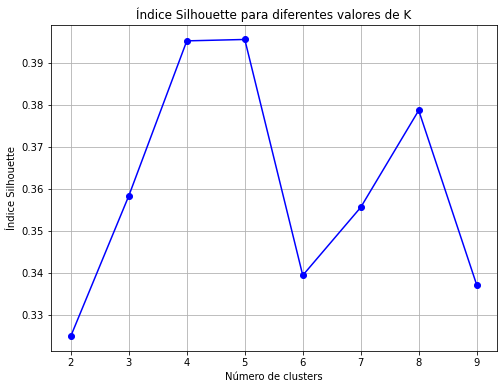

In [6]:
# Determinar la cantidad óptima de clusters usando el índice de silueta
silhouette_scores = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_pred = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels_pred))

# Graficar los valores del índice de silueta
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Número de clusters")
plt.ylabel("Índice Silhouette")
plt.title("Índice Silhouette para diferentes valores de K")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [7]:
# seleccionar el valor de K anterior al 1er descenso del valor del índice
i = 0
while (i < len(silhouette_scores) - 1) and (silhouette_scores[i] < silhouette_scores[i + 1]):
    i += 1

best_k = k_values[i]
print(f"Número óptimo de clusters: {best_k}")

Número óptimo de clusters: 5


## Determinar la cantidad óptima de clusters usando el índice Davies-Bouldin

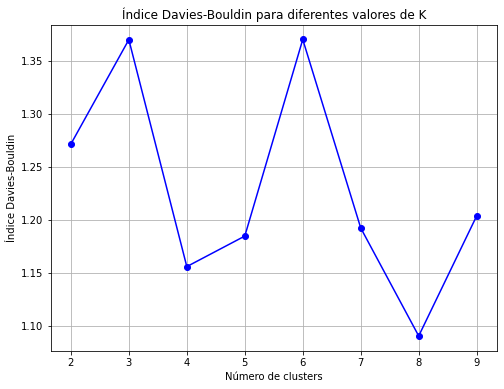

In [8]:
# Determinar la cantidad óptima de clusters usando el índice Davies-Bouldin
davies_bouldin_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_pred = kmeans.fit_predict(X_scaled)
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels_pred))
    
# Graficar los valores del índice de silueta
plt.figure(figsize=(8, 6))
plt.plot(k_values, davies_bouldin_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Número de clusters")
plt.ylabel("Índice Davies-Bouldin")
plt.title("Índice Davies-Bouldin para diferentes valores de K")
plt.xticks(k_values)
plt.grid(True)
plt.show()    

In [9]:
# seleccionar el valor de K anterior al 1er ascenso del valor del índice
i = 0
while (i < len(silhouette_scores) - 1) and (davies_bouldin_scores[i] > davies_bouldin_scores[i + 1]):
    i += 1

best_k = k_values[i]
print(f"Número óptimo de clusters: {best_k}")

Número óptimo de clusters: 2


## Aplicar K-Means con el número óptimo de clusters

In [10]:

K = best_k
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Obtener los centroides
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_features.columns).round(4)
print("Centroides:")
print(centroids.T)

Centroides:
                    0       1       2       3
Tiene_Pelo    -0.0000  1.0000 -0.0000  0.2222
Tiene_Plumas   0.9524 -0.0000 -0.0000 -0.0000
Nace_de_huevo  1.0000  0.0256  0.8696  0.9444
Toma_Leche    -0.0000  1.0000  0.0870 -0.0000
Vuela          0.7619  0.0513 -0.0000  0.3333
Acuatico       0.2857  0.1026  0.8696  0.3333
Depredador     0.4286  0.5128  0.7826  0.5000
Dentado        0.0000  0.9744  1.0000  0.0000
Vertebrado     1.0000  1.0000  1.0000  0.0000
Respira        1.0000  1.0000  0.3913  0.6111
Venenoso      -0.0000 -0.0000  0.1739  0.2222
Tiene_Aletas  -0.0000  0.0513  0.6522  0.0000
Cant_Patas     0.2619  0.4423  0.1087  0.5903
Tiene_Cola     1.0000  0.8462  0.8696  0.0556
Domestico      0.1429  0.2051  0.0435  0.0556
Tamano_Gato    0.3333  0.7692  0.2609  0.0556


In [11]:
# Contar la cantidad de animales de cada especie en cada cluster
conteo = df.groupby(['Cluster', 'Clase']).size().unstack(fill_value=0)
print("Cantidad de animales de cada especie en cada cluster:")
print(conteo)


Cantidad de animales de cada especie en cada cluster:
Clase    Anfibio  Ave  Insecto  Invertebrado  Mamifero  Pez  Reptil
Cluster                                                            
0              0   20        0             0         0    0       1
1              0    0        0             0        39    0       0
2              4    0        0             0         2   13       4
3              0    0        8            10         0    0       0


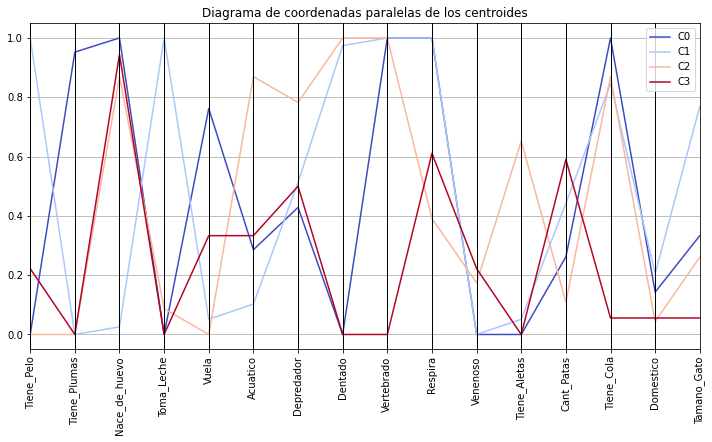

In [12]:
# Diagrama de coordenadas paralelas de los centroides
#centroids['Cluster'] = [f'C{i}' for i in range(best_k)]
centroids['Cluster'] = [f'C{i}' for i in range(K)]
plt.figure(figsize=(12, 6))
parallel_coordinates(centroids, class_column='Cluster', colormap='coolwarm')
plt.title("Diagrama de coordenadas paralelas de los centroides")
plt.xticks(rotation=90)
plt.show()


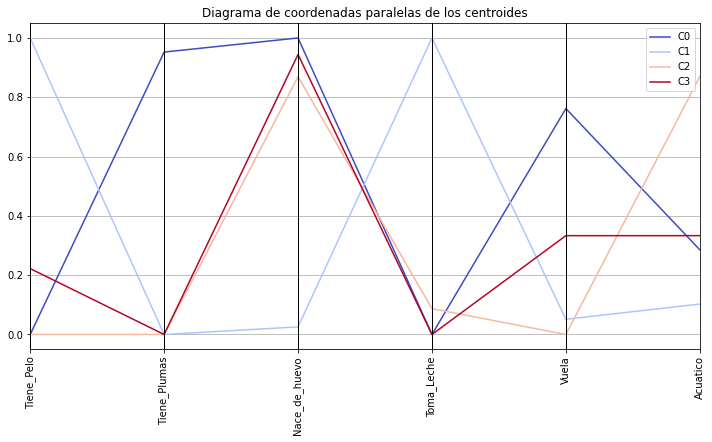

In [13]:
# Utilizando sólo las primeras 6 características
df_reducido = pd.concat([centroids.iloc[:, :6], centroids.iloc[:, -1]], axis=1)

plt.figure(figsize=(12, 6))
parallel_coordinates(df_reducido, class_column='Cluster', colormap='coolwarm')
plt.title("Diagrama de coordenadas paralelas de los centroides")
plt.xticks(rotation=90)
plt.show()